# Turn Sign Classification using NN

- Author: Yiran Jing
- Date: 17 Sep 2020
- Version: 0 (Frist try)

## Content 
1. EDA
2. Feature Engineering
    1. Configure the dataset for performance
    2. Standardize the data
4. Train and Test model 
    - 20% as test data
    - 5 layter the same as example
    - Adjusting overfit by Dropout, augmented images, and recrease epochs
5. Appendix: Visualization data augmented examples

### Dataset description

The data [turn_signs_color_filtered](https://github.com/wallarug/tensorflow-training-ground)

- Two Main Class: right-turn and left-turn
- The dataset include `52` images
  - 37 colored left turn images
  - 15 colored right turn images




## Key Limitation of first try model
1. Not enough images, and unbalanced dataset
   - Will have more data in the following weeks
2. NN without any hyper-parameter turning
   - We should learn NN first, and keep improving model
3. No baseline 
   - (Try some basic statistical model, for example, multi-logistic regression, to get some easy understanding insight)
4. No data cleaning 
   - (It is necessary, if our dataset includes some useless images)
4. No feature engineering
   - Create a valuable dataset is as important as training model

In [1]:
import matplotlib.pyplot as plt
from os import listdir, rename, listdir
from pathlib import Path
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Load dataset and visualization

In [2]:
figure_format = 'png'

In [3]:
path = "turn_signs_color_filtered/train/left"
left_image_count = len(listdir(path))
print("There are {} colored left turn images.".format(left_image_count))

path = "turn_signs_color_filtered/train/right"
right_image_count = len(listdir(path))
print("There are {} colored right turn images.".format(right_image_count))

There are 37 colored left turn images.
There are 15 colored right turn images.


In [4]:
data_dir = pathlib.Path('turn_signs_color_filtered/train')
image_count = len(list(data_dir.glob('*/*.png')))
print("The total number of turning images are {} ".format(image_count))

The total number of turning images are 52 


In [5]:
left = list(data_dir.glob('left/*'))
PIL.Image.open(str(left[0]))

In [6]:
right = list(data_dir.glob('right/*'))
PIL.Image.open(str(right[0]))

In [7]:
# Predefined Hyper-parameter 
learning_rate = 0.001
batch_size = 64

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2, # 20% as testing data
  subset="training",
  seed=123,
  #image_size=(img_height, img_width),
  batch_size=batch_size)

Found 52 files belonging to 2 classes.
Using 42 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  #image_size=(img_height, img_width),
  batch_size=batch_size)

Found 52 files belonging to 2 classes.
Using 10 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names) # we only consider 2 classes here.

['left', 'right']


#### Visualization training data

before we train the model, let's firstly, visualize some training data

From image below, we can see that 

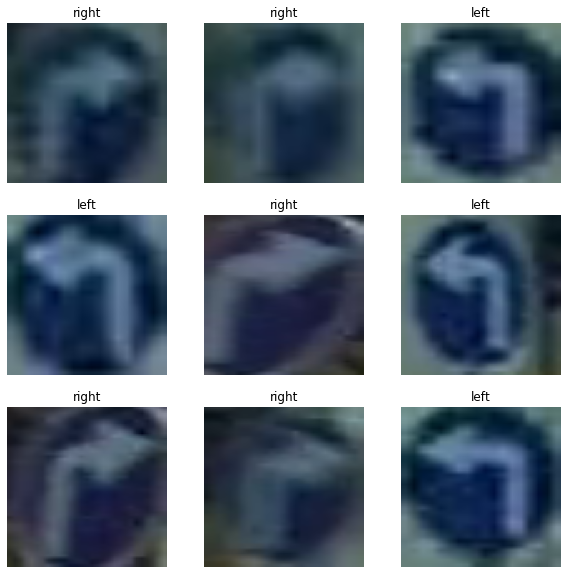

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(42, 256, 256, 3)
(42,)


The `image_batch` is a tensor of the shape `(42, 256, 256, 3)`. This is a batch of 42 images of shape `256x256x3` (the last dimension referes to color channels RGB). The `label_batch` is a tensor of the shape `(42,)`, these are corresponding labels to the 32 images. 

In [13]:
img_height = 256
img_width = 256

### Feature Engineering
1. Configure the dataset for performance
2. Standardize the data


#### Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

- `Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. 

- `Dataset.prefetch()` overlaps data preprocessing and model execution while training. 

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Standardize the data
The RGB channel values are in the `[0, 255]` range. 
We standardize values to be in the `[0, 1]` by using a Rescaling layer.

In [15]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [16]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 0.6587297


### Train Model

The model consists of three `convolution blocks` with a `max pool layer` in each of them. There's a fully connected layer with 128 units on top of it that is activated by a `relu` activation function. This model has not been tuned for high accuracy, just randomly selected

`relu = max(0, x)`. 

In [17]:
def train_Visualize_CNN(model, 
                        epochs,
                        train_ds, val_ds):
            
    # model compile
    # using Adam optimizer
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
            
        
    print(model.summary())
    
    #train model     
    cnn = model.fit(
          train_ds,
          validation_data=val_ds,
          epochs=epochs
        )
    
    return cnn

In [18]:
num_classes = 2
epochs = 10
cnn_1 = Sequential([
          #data_augmentation,
          layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
          layers.Conv2D(16, 3, padding='same', activation='relu'),
          layers.MaxPooling2D(),
          layers.Conv2D(32, 3, padding='same', activation='relu'),
          layers.MaxPooling2D(),
          layers.Conv2D(64, 3, padding='same', activation='relu'),
          layers.MaxPooling2D(),
          #layers.Dropout(drop_out), # drop out rate
          layers.Flatten(),
          layers.Dense(128, activation='relu'), # 不懂 16 32 64 128这些是怎么来的 什么逻辑
          layers.Dense(num_classes)
            ])

cnn_1 = train_Visualize_CNN(cnn_1,
                            epochs, 
                            train_ds = train_ds, 
                            val_ds = val_ds)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0

In [19]:
def plot_train_result(model_result, epoch):
    acc = model_result.history['accuracy']
    val_acc = model_result.history['val_accuracy']

    loss=model_result.history['loss']
    val_loss=model_result.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

#### Visualize results

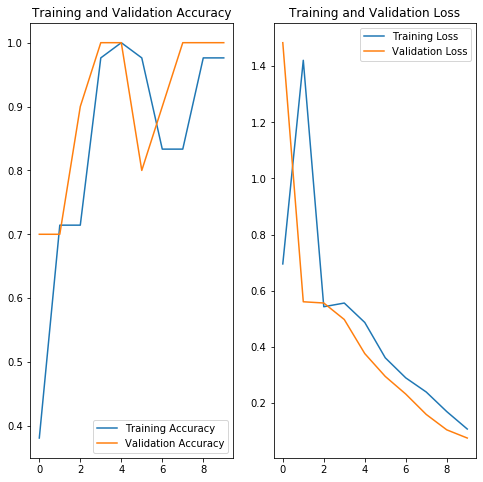

In [20]:
plot_train_result(cnn_1, epochs)

From the plot above, we can see that the test accuracy is increasing and then decreasing around epoch = 4. 

### Deal with Overfitting
Create a new neural network using layers.Dropout, then train it using augmented images.
Here, try:
- *data augmentation* 
- add *Dropout* 

#### 1. Decreate the number of epoches


#### 1. Data augmentation

Generating additional training data from your existing examples by augmenting then using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

#### 2. Dropout
A form of regularization. It randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process.


In [21]:
### Visualization data augmented examples

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [22]:
num_classes = 2
epochs = 10
cnn_2 = Sequential([
          data_augmentation,
          layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
          layers.Conv2D(16, 3, padding='same', activation='relu'),
          layers.MaxPooling2D(),
          layers.Conv2D(32, 3, padding='same', activation='relu'),
          layers.MaxPooling2D(),
          layers.Conv2D(64, 3, padding='same', activation='relu'),
          layers.MaxPooling2D(),
          layers.Dropout(0.2), # drop out rate 
          layers.Flatten(),
          layers.Dense(128, activation='relu'), # 不懂 16 32 64 128这些是怎么来的 什么逻辑
          layers.Dense(num_classes)
            ])

cnn_2 = train_Visualize_CNN(cnn_2,
                            epochs, 
                            train_ds = train_ds, 
                            val_ds = val_ds)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 64)       

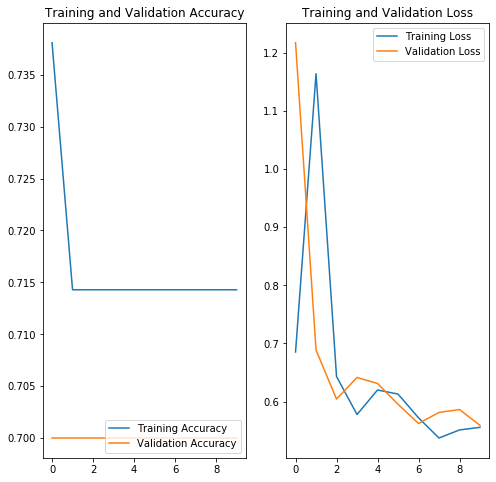

In [23]:
plot_train_result(cnn_2, epochs)

### Appendix: Visualization data augmented examples

visualize what a few augmented examples look like by applying data augmentation to the same image several times

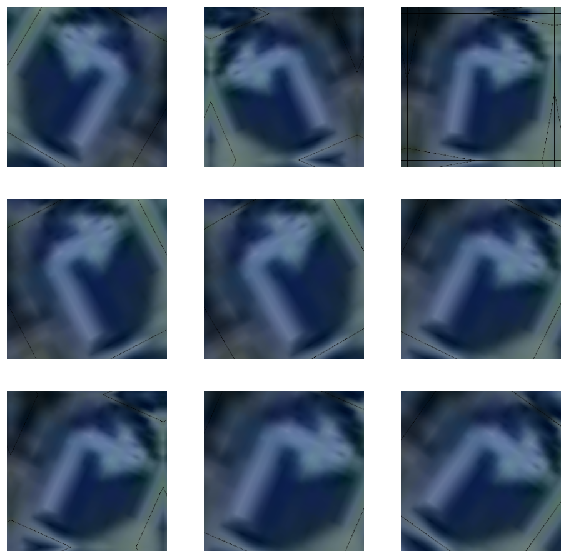

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")